## Heart Disease Detection
Build a system that can predict if a patient has heart disease. Explore the data, understand the features, and figure out an approach.

In [1]:
# Import Libraries
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report,roc_auc_score, roc_curve, RocCurveDisplay
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectFromModel

import pickle

### Custom Functions

In [2]:
# Fucntion to filter outliers for numerical columns
def remove_outlier(numeric_col, df):

    for col in numeric_col:

        # Set upper and lower fench
        q1, q3 = df[col].quantile([0.25,0.75])
        iqr = q3-q1
        lower_fench, upper_fench = q1-1.5*iqr, q3+1.5*iqr

        # Create mask 
        outlier_mask = df[col].between(lower_fench, upper_fench)
        df = df[outlier_mask]
    
    return df

## Load the data

In [3]:
df = pd.read_csv("heart-disease.csv")

# Shape
print(df.shape)
df.head()

(1190, 12)


,age,sex,chest pain type,resting bp s,cholesterol,fasting blood sugar,resting ecg,max heart rate,exercise angina,oldpeak,ST slope,target
0,40,1,2,140,289,0,0,172,0,0.0,1,0
1,49,0,3,160,180,0,0,156,0,1.0,2,1
2,37,1,2,130,283,0,1,98,0,0.0,1,0
3,48,0,4,138,214,0,0,108,1,1.5,2,1
4,54,1,3,150,195,0,0,122,0,0.0,1,0


In [4]:
# Check the information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1190 entries, 0 to 1189
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  1190 non-null   int64  
 1   sex                  1190 non-null   int64  
 2   chest pain type      1190 non-null   int64  
 3   resting bp s         1190 non-null   int64  
 4   cholesterol          1190 non-null   int64  
 5   fasting blood sugar  1190 non-null   int64  
 6   resting ecg          1190 non-null   int64  
 7   max heart rate       1190 non-null   int64  
 8   exercise angina      1190 non-null   int64  
 9   oldpeak              1190 non-null   float64
 10  ST slope             1190 non-null   int64  
 11  target               1190 non-null   int64  
dtypes: float64(1), int64(11)
memory usage: 111.7 KB


#### Comment:
There is 1190 observations and 12 columns (with no missing values and no object type)

In [5]:
# Separate columns according their data types
numeric_col = ['age', 'resting bp s', 'cholesterol', 'max heart rate', 'oldpeak']
binary_col = ['sex', 'fasting blood sugar',  'exercise angina']
nominal_col = ['chest pain type', 'resting ecg', 'ST slope']

### Check for outliers

In [6]:
# For categorical features
for col in binary_col:
    print(f"{df[col].value_counts()}\n") 

sex
1    909
0    281
Name: count, dtype: int64

fasting blood sugar
0    936
1    254
Name: count, dtype: int64

exercise angina
0    729
1    461
Name: count, dtype: int64



In [7]:
# For categorical features
for col in nominal_col:
    print(f"{df[col].value_counts()}\n") 

chest pain type
4    625
3    283
2    216
1     66
Name: count, dtype: int64

resting ecg
0    684
2    325
1    181
Name: count, dtype: int64

ST slope
2    582
1    526
3     81
0      1
Name: count, dtype: int64



**Comment:**

There is one extra category in column "ST slope" and that is 0 (there is only one observatio for it), but there is no information about this category in data information table. So, we can consider it as an outlier and should drop the observation for this category.

In [8]:
# Remove the outlier
mask_stslope = df["ST slope"]!=0
df = df[mask_stslope]

df.shape

(1189, 12)

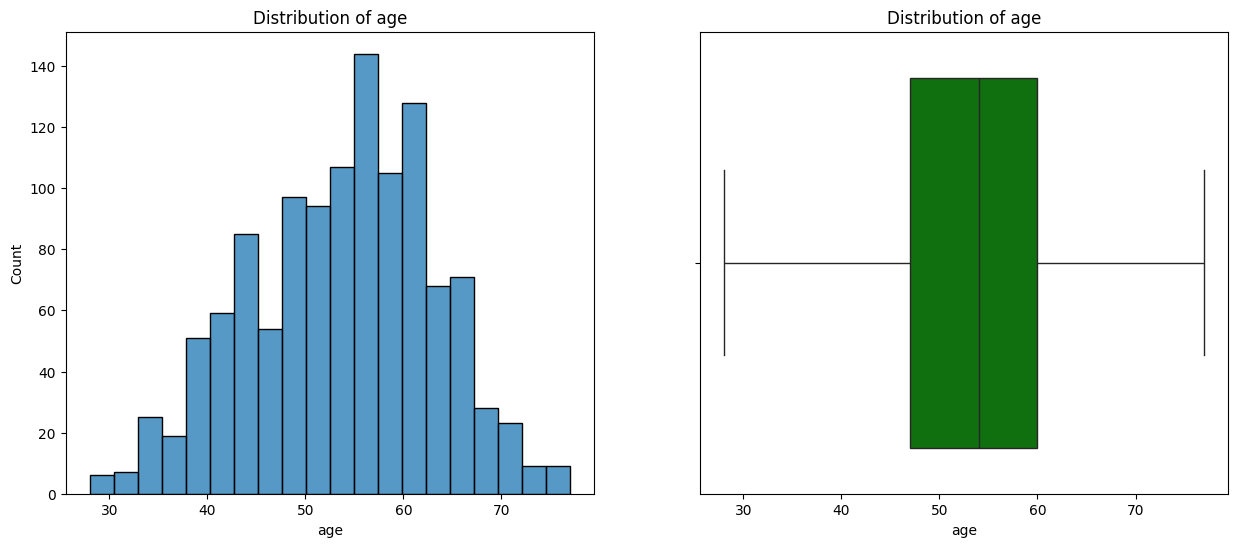

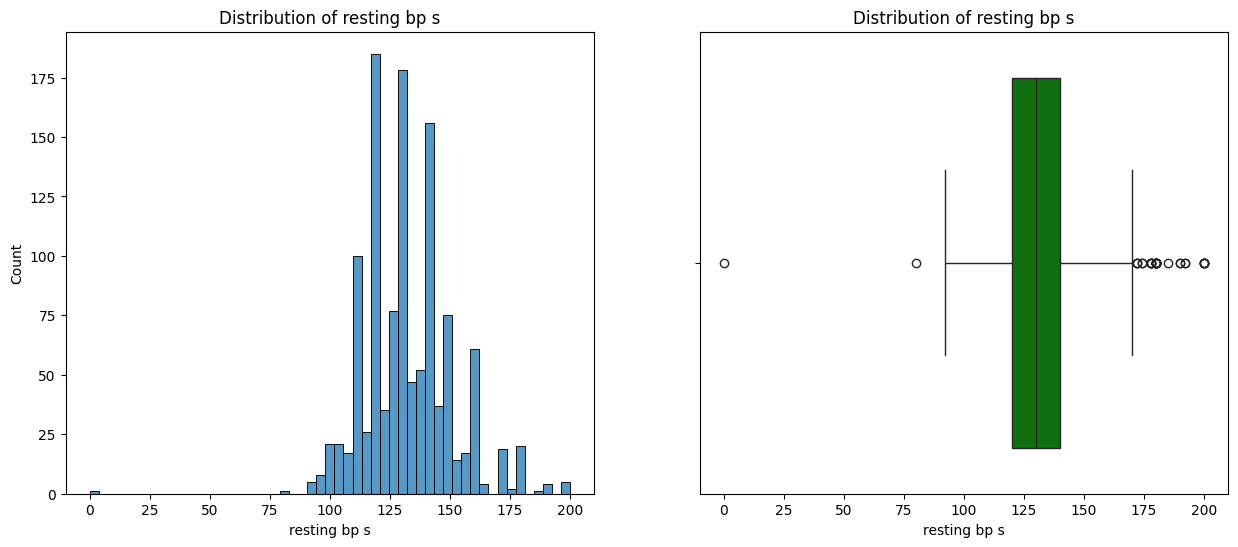

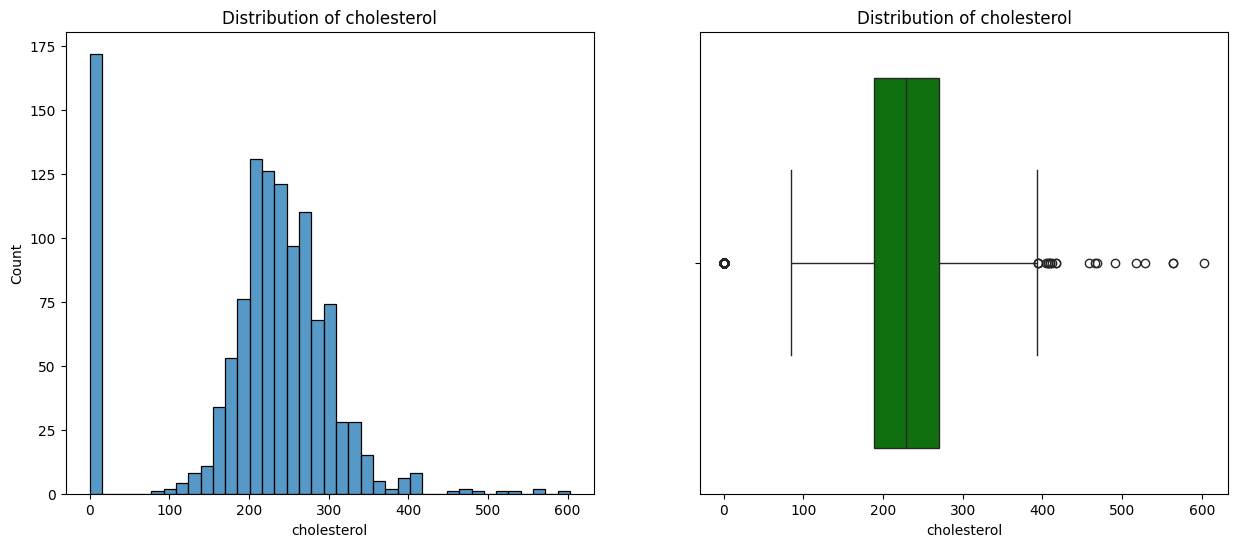

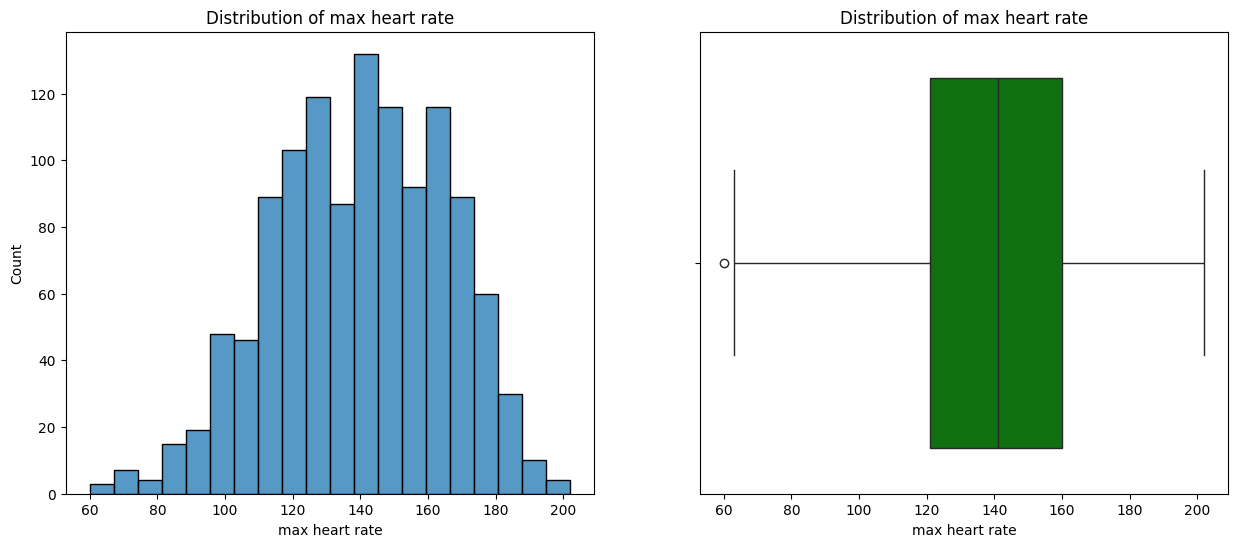

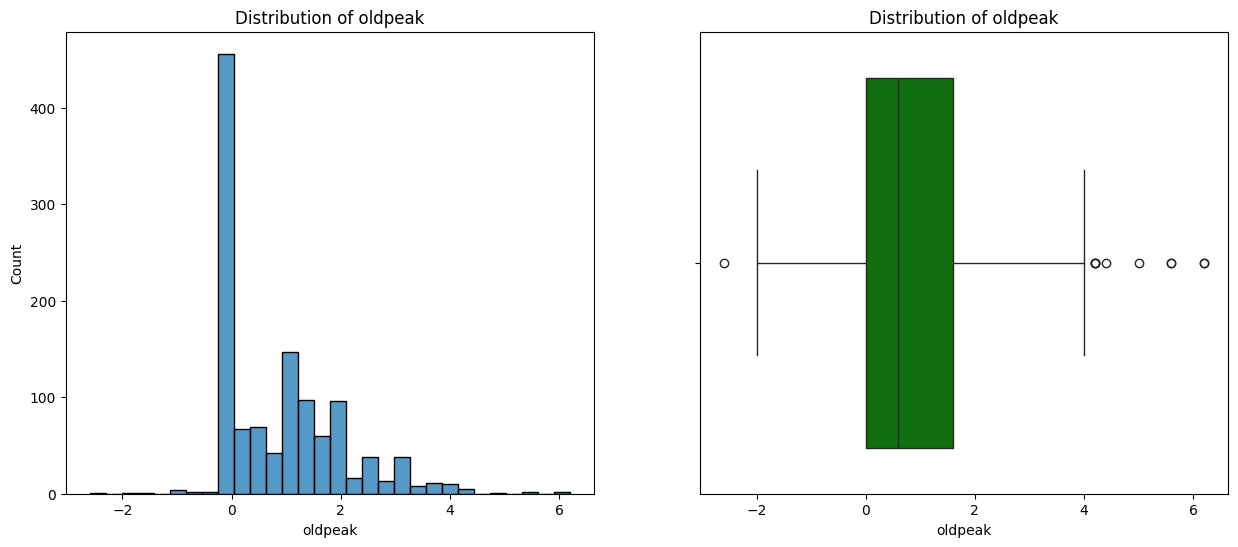

In [9]:
# For numerical columns
for col in numeric_col:
    plt.figure(figsize=(15,6))

    # Histogram
    plt.subplot(1,2,1)
    sns.histplot(df[col])
    plt.title(f"Distribution of {col}")

    # Box plot
    plt.subplot(1,2,2)
    sns.boxplot(df[col], orient='h', color='g')
    plt.title(f"Distribution of {col}")

**Comment:**

We are seeing that there are some nummerical columns contains outliers. So, we should remove those outliers.

In [10]:
# Remove outliers
df = remove_outlier(numeric_col, df)

print(df.shape)
df.head()

(951, 12)


,age,sex,chest pain type,resting bp s,cholesterol,fasting blood sugar,resting ecg,max heart rate,exercise angina,oldpeak,ST slope,target
0,40,1,2,140,289,0,0,172,0,0.0,1,0
1,49,0,3,160,180,0,0,156,0,1.0,2,1
2,37,1,2,130,283,0,1,98,0,0.0,1,0
3,48,0,4,138,214,0,0,108,1,1.5,2,1
4,54,1,3,150,195,0,0,122,0,0.0,1,0


### Explore the data more

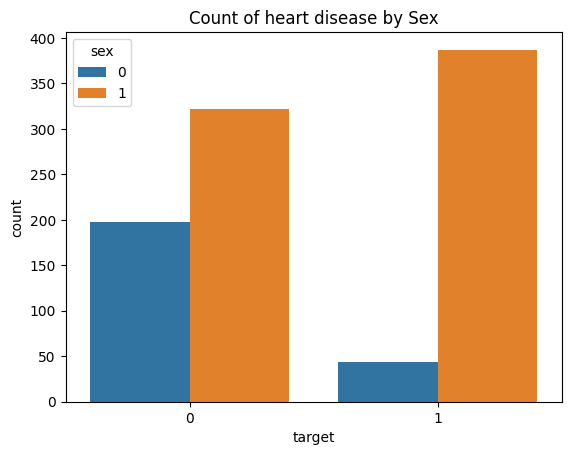

In [11]:
# Explore which gender has more heart disease
sns.countplot(x='target', hue='sex', data=df)
plt.title('Count of heart disease by Sex')
plt.show()

**Comment:**

Male suffers in heart disease more than female

Text(0.5, 1.0, 'Heart disease base on age group')

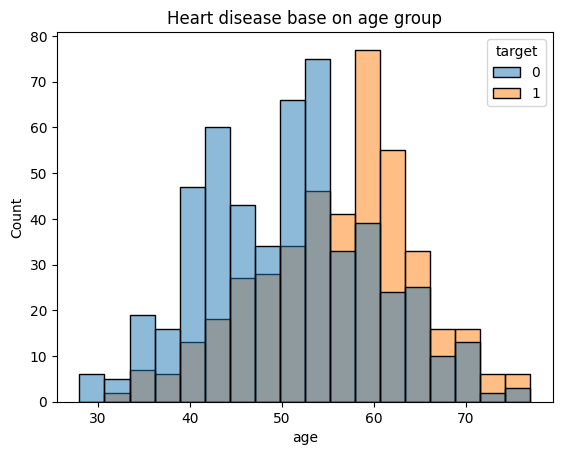

In [12]:
# Explore which age category peoples are suffering from heart disease most
sns.histplot(x="age", hue='target', data=df)
plt.title("Heart disease base on age group")

**Comment:**

Peoples are of age near about 60 suffers in heart disease the most.

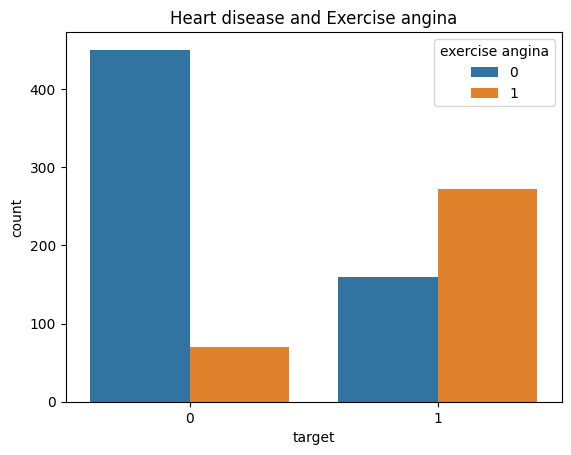

In [13]:
# How heart disease and exercise angina related to each other
sns.countplot(x='target', hue='exercise angina', data=df)
plt.title("Heart disease and Exercise angina");

**Comment:**

People with heart disease suffers more in exercise angina (pain in chest during exercise) than people who are not suffering in heart disease.

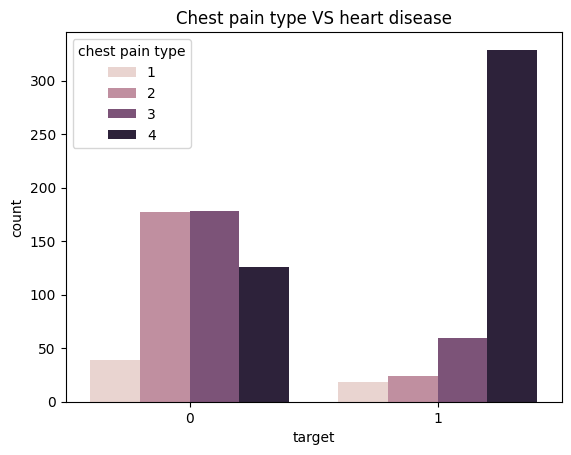

In [41]:
# Check how chest pain type affect to heart disease rate
sns.countplot(x='target', hue='chest pain type', data=df)
plt.title("Chest pain type VS heart disease");

**Comment:**

It shows that if a person has chest pain of type 4 (asymptomatic chest pain) then it is highly probable that he/she is suffering from heart disease.

### Check the whether data is balanced

In [14]:
# Check the data balance or not
df['target'].value_counts()

target
0    520
1    431
Name: count, dtype: int64

**Comment:**

Data is nearly balanced

### Wrangle Function
Use the wrangle function to perform all above data wrangling steps at once

In [15]:
def wrangle(path):
    df = pd.read_csv(path)

    # Remove the outlier
    mask_stslope = df["ST slope"]!=0
    df = df[mask_stslope]

    df = remove_outlier(numeric_col, df)
    
    return df

df = wrangle("heart-disease.csv")
df.shape

(951, 12)

## Data Splitting

In [16]:
# Split into target and features
target = 'target'
features = numeric_col + nominal_col + binary_col

# Make the dataframe
X = df[features]
y = df[target]

# Shape
print("Shape of X: ", X.shape)
print("Shape of y: ", y.shape)

Shape of X:  (951, 11)
Shape of y:  (951,)


In [17]:
# Split the data into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Shape
print("X_trian_shape: ", X_train.shape)
print("y_trian_shape: ", y_train.shape)
print("X_test_shape: ", X_test.shape)
print("y_test_shape: ", y_test.shape)

X_trian_shape:  (760, 11)
y_trian_shape:  (760,)
X_test_shape:  (191, 11)
y_test_shape:  (191,)


## Model Building and Evaluation

### Pipeline

In [18]:
# Pipeline for each column
numeric_pipeline = Pipeline([
    ('scaler', StandardScaler())
])

nominal_pipeline = Pipeline([
    ('ohe', OneHotEncoder())
])

# add a passthrough pipeline for binaries
binary_pipeline = Pipeline([
    # no transforms – just passes the column through
    ('passthrough', 'passthrough')
])

# Column transformer
preprocessor = ColumnTransformer([
    ('num', numeric_pipeline, numeric_col),
    ('nom', nominal_pipeline, nominal_col),
    ('bin', binary_pipeline, binary_col)
])

# Final pipeline
model_pipeline = Pipeline([
    ('preproc', preprocessor),
    ('feature_select', SelectFromModel(
        estimator=RandomForestClassifier(n_estimators=100), 
        threshold=0.01
    )),
    ('model', LogisticRegression())
])


# Fit the data for estimation of parameters
model_pipeline.fit(X_train, y_train)

,steps,"[('preproc', ...), ('feature_select', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('nom', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


### Evaluation

In [19]:
# Training accuracy
y_train_pred = model_pipeline.predict(X_train)

# Check accuracy
print(classification_report(y_pred=y_train_pred, y_true=y_train))

              precision    recall  f1-score   support

           0       0.87      0.84      0.86       406
           1       0.82      0.86      0.84       354

    accuracy                           0.85       760
   macro avg       0.85      0.85      0.85       760
weighted avg       0.85      0.85      0.85       760



In [20]:
# Testing accuracy
y_test_pred = model_pipeline.predict(X_test)

# Evaluation report
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.85      0.89      0.87       114
           1       0.83      0.77      0.80        77

    accuracy                           0.84       191
   macro avg       0.84      0.83      0.83       191
weighted avg       0.84      0.84      0.84       191



## Try with Decision Tree

In [21]:
# DT pipeline
dt_pipeline = Pipeline([
    ('preproc', preprocessor),
    ('model', DecisionTreeClassifier(random_state=42, min_samples_leaf=4, max_depth=9))
])


# Fit the data for estimation of parameters
dt_pipeline.fit(X_train, y_train)

,steps,"[('preproc', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('nom', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [22]:
# Training accuracy
y_train_pred = dt_pipeline.predict(X_train)

# Check accuracy
print(classification_report(y_pred=y_train_pred, y_true=y_train))

              precision    recall  f1-score   support

           0       0.94      0.95      0.94       406
           1       0.94      0.93      0.94       354

    accuracy                           0.94       760
   macro avg       0.94      0.94      0.94       760
weighted avg       0.94      0.94      0.94       760



In [23]:
# Testing accuracy
y_test_pred = dt_pipeline.predict(X_test)

# Evaluation report
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.88      0.88      0.88       114
           1       0.82      0.83      0.83        77

    accuracy                           0.86       191
   macro avg       0.85      0.85      0.85       191
weighted avg       0.86      0.86      0.86       191



**Comment:**

It gives us the accuracy for taining set 94 and testing set is 86. It seems little bit overfitting. Let's try with another model.

## Random Forest Classifier

In [24]:
# RFC pipeline
rfc_pipeline = Pipeline([
    ('preproc', preprocessor),
    ('model', RandomForestClassifier(random_state=42, min_samples_leaf=4, max_depth=8))
])


# Fit the data for estimation of parameters
rfc_pipeline.fit(X_train, y_train)

,steps,"[('preproc', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('nom', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [25]:
# Training accuracy
y_train_pred = rfc_pipeline.predict(X_train)

# Check accuracy
print(classification_report(y_pred=y_train_pred, y_true=y_train))

              precision    recall  f1-score   support

           0       0.93      0.94      0.94       406
           1       0.93      0.92      0.93       354

    accuracy                           0.93       760
   macro avg       0.93      0.93      0.93       760
weighted avg       0.93      0.93      0.93       760



In [26]:
# Testing accuracy
y_test_pred = rfc_pipeline.predict(X_test)

# Evaluation report
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.94      0.90      0.92       114
           1       0.86      0.91      0.89        77

    accuracy                           0.91       191
   macro avg       0.90      0.91      0.90       191
weighted avg       0.91      0.91      0.91       191



**Comment:**

Our random forest classifier is doing better than our Decision Tree and Logistic regression model. Let's try to tune this model.

In [27]:
# Feature importance
rfc_pipeline.named_steps['model'].feature_importances_

array([0.06261822, 0.05765997, 0.0418307 , 0.07587663, 0.10411558,
       0.00420621, 0.02144596, 0.01857157, 0.1491226 , 0.00937151,
       0.00322271, 0.01410252, 0.13232684, 0.12767325, 0.00379254,
       0.05464679, 0.00547841, 0.11393799])

In [28]:
# Features
rfc_pipeline[0].get_feature_names_out()

array(['num__age', 'num__resting bp s', 'num__cholesterol',
       'num__max heart rate', 'num__oldpeak', 'nom__chest pain type_1',
       'nom__chest pain type_2', 'nom__chest pain type_3',
       'nom__chest pain type_4', 'nom__resting ecg_0',
       'nom__resting ecg_1', 'nom__resting ecg_2', 'nom__ST slope_1',
       'nom__ST slope_2', 'nom__ST slope_3', 'bin__sex',
       'bin__fasting blood sugar', 'bin__exercise angina'], dtype=object)

## Tune the model's  hyperparameters

### Grid search CV

In [29]:
# Parameters grid
param_grid = {
    'model__n_estimators':[100,125,150],
    'model__max_depth':[6,7,8],
    'model__min_samples_leaf':[3,4,5]
}

# Grid search instantiation
rf_grid = GridSearchCV(rfc_pipeline, param_grid, cv=5)

# Estimate
rf_grid.fit(X_train, y_train)

,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'model__max_depth': [6, 7, ...], 'model__min_samples_leaf': [3, 4, ...], 'model__n_estimators': [100, 125, ...]}"
,scoring,None
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('num', ...), ('nom', ...), ...]"


In [30]:
# Get the best combinations
print("Best Parameters: ", rf_grid.best_params_)

# Best score
print("Best Score: ", rf_grid.best_score_)

Best Parameters:  {'model__max_depth': 8, 'model__min_samples_leaf': 3, 'model__n_estimators': 100}
Best Score:  0.8921052631578947


In [31]:
# Best model from grid search
best_rfc = rf_grid.best_estimator_

In [32]:
# Training accuracy
y_train_pred = best_rfc.predict(X_train)

# Check accuracy
print(classification_report(y_pred=y_train_pred, y_true=y_train))

              precision    recall  f1-score   support

           0       0.94      0.95      0.94       406
           1       0.94      0.94      0.94       354

    accuracy                           0.94       760
   macro avg       0.94      0.94      0.94       760
weighted avg       0.94      0.94      0.94       760



In [33]:
# Testing accuracy
y_test_pred = best_rfc.predict(X_test)

# Evaluation report
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.93      0.91      0.92       114
           1       0.87      0.90      0.88        77

    accuracy                           0.91       191
   macro avg       0.90      0.90      0.90       191
weighted avg       0.91      0.91      0.91       191



## Final Model
As our random forest model (rfc_pipeline) performing better, so we take as our final model

In [34]:
final_model = rfc_pipeline

Test ROC‐AUC = 0.965


e:\Learning\Coding\AI\02 - Machine Learning\Machine-Learning-Projects\ml_venv\Lib\site-packages\sklearn\utils\_plotting.py:379: FutureWarning: `estimator_name` is deprecated in 1.7 and will be removed in 1.9. Use `name` instead.
  warnings.warn(


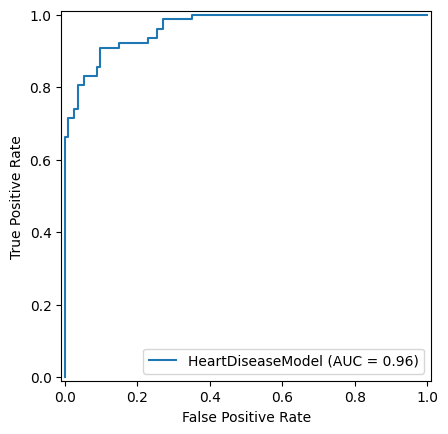

In [35]:
# Get the probability estimates for the “disease” class (label=1)
y_proba = final_model.predict_proba(X_test)[:, 1]

#  Compute ROC‐AUC
auc = roc_auc_score(y_test, y_proba)
print(f"Test ROC‐AUC = {auc:.3f}")

# Plot the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
disp = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc,
                       estimator_name="HeartDiseaseModel")
disp.plot()
plt.show()

## Save and use the final model

In [36]:
# Save the model
with open('model.pkl', 'wb') as f:
    pickle.dump(final_model, f)

In [37]:
# Load the model
with open('model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

#### Prediction with loaded model

In [38]:
# Test prediction
y_pred = loaded_model.predict(X_test)

# Make a dataframe with actual and predicted values
df_pred = pd.DataFrame(data={'y_actual': y_test, 'y_predicted': y_pred})
df_pred.head()

,y_actual,y_predicted
213,0,0
622,0,0
914,0,0
972,0,0
713,0,1


In [39]:
# Prediction data frame with tagged
df_pred['pred_label'] = df_pred['y_predicted'].map({0: 'No heart disease', 1: 'Heart disease'})
df_pred.head()

,y_actual,y_predicted,pred_label
213,0,0,No heart disease
622,0,0,No heart disease
914,0,0,No heart disease
972,0,0,No heart disease
713,0,1,Heart disease


In [40]:
# Add predicion status to the pred_df
df_pred['status'] = (df_pred["y_actual"]==df_pred["y_predicted"]).apply(lambda obs: 'Correct prediction' if obs==True else "Wrong prediction" )

# See any random 10 prediction
df_pred.sample(10)

,y_actual,y_predicted,pred_label,status
81,0,0,No heart disease,Correct prediction
526,0,0,No heart disease,Correct prediction
931,1,1,Heart disease,Correct prediction
518,1,1,Heart disease,Correct prediction
599,1,1,Heart disease,Correct prediction
271,0,0,No heart disease,Correct prediction
151,0,0,No heart disease,Correct prediction
1018,0,0,No heart disease,Correct prediction
720,1,1,Heart disease,Correct prediction
899,1,1,Heart disease,Correct prediction
